In [ ]:
!pip install pycaret

In [2]:
import plotly.express as px
import pandas as pd
import numpy as np
coor=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEVX_st/meteorological_models/distan_lat42.225lon-8.63p10R4Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="Nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
import pandas as pd
station_all=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEVX_st/meteorological_station/LEVX.csv",parse_dates=["time"]).drop(columns=["Unnamed: 0"]).set_index("time")
print(station_all)
station_all["wind_gust_o"].describe()

                         temp_o     tempd_o    rh_o  dir_o     spd_o  \
time                                                                   
2008-01-01 00:00:00  278.550001  277.950000   95.91  220.0  3.601108   
2008-01-01 01:00:00  278.050000  277.450001   95.89  230.0  3.086664   
2008-01-01 02:00:00  278.050000  277.649999   97.24  190.0  5.144440   
2008-01-01 02:30:00  276.150001  275.149999   93.14  240.0  3.601108   
2008-01-01 03:00:00  278.750001  277.549999   91.98  230.0  3.086664   
...                         ...         ...     ...    ...       ...   
2020-12-24 21:30:00  278.150000  278.150000  100.00   50.0  2.572220   
2020-12-24 22:00:00  278.150000  277.150000   93.24   60.0  2.057776   
2020-12-24 22:30:00  278.150000  277.150000   93.24   80.0  1.543332   
2020-12-24 23:00:00  278.150000  277.150000   93.24   30.0  3.601108   
2020-12-24 23:30:00  278.150000  277.150000   93.24   40.0  3.086664   

                    wind_gust_o  mslp_o  visibility_o skyc1_o s

count     229250
unique        48
top            M
freq      219768
Name: wind_gust_o, dtype: object

In [4]:
#resample max gust  hour before
station=station_all[["wind_gust_o","temp_o"]].resample("H",label="right").max()


In [5]:
from locale import normalize
station["wind_gust_o"].value_counts()
#station["wind_gust_o"].plot.hist();

M                     111356
13.375544                141
12.346656                130
13.889988                128
12.8611                  127
9.774436                 125
11.832212                122
14.404432                119
14.918876000000001       110
15.947764000000001        99
15.43332                  93
16.976652                 86
16.462208                 83
11.317768000000001        72
9.259992                  63
17.491096                 62
18.00554                  58
10.803324                 47
8.745548                  41
18.519984                 34
19.034428000000002        32
10.28888                  31
19.548872                 26
8.231104                  25
20.063316                 22
21.606648                 22
20.57776                  21
21.092204                 21
22.635536000000002        15
7.71666                   12
23.14998                  11
22.121092                 10
23.664424                  7
24.178868                  6
25.7222       

**Multi label**

In [6]:
#gust to  interval

interval=pd.IntervalIndex.from_tuples([(0, 12.8611),(12.8611,500)])
labels=["<=25KT",">25KT" ]       
station["gust_l"]=pd.cut(pd.to_numeric(station["wind_gust_o"],errors="coerce"), 
                         bins=interval,retbins=False,labels=labels)
station["gust_l"] = station["gust_l"].map({a:b for a,b in zip(interval,labels)})

#no gust "NG"
station["gust_l"] = station["gust_l"].astype(str).replace("nan","NG")
station=station.drop(columns=["temp_o"])
print(station.value_counts())
print(station["gust_l"].value_counts(normalize=True))

wind_gust_o         gust_l
M                   NG        111356
13.375544           >25KT        141
12.346656           <=25KT       130
13.889988           >25KT        128
12.8611             <=25KT       127
9.774436            <=25KT       125
11.832212           <=25KT       122
14.404432           >25KT        119
14.918876000000001  >25KT        110
15.947764000000001  >25KT         99
15.43332            >25KT         93
16.976652           >25KT         86
16.462208           >25KT         83
11.317768000000001  <=25KT        72
9.259992            <=25KT        63
17.491096           >25KT         62
18.00554            >25KT         58
10.803324           <=25KT        47
8.745548            <=25KT        41
18.519984           >25KT         34
19.034428000000002  >25KT         32
10.28888            <=25KT        31
19.548872           >25KT         26
8.231104            <=25KT        25
21.606648           >25KT         22
20.063316           >25KT         22
21.092204  

**Binary label**

**Gust on time T means on time T**

In [15]:
# no resample hour before
#station=station_all[["wind_gust_o","temp_o"]].resample("H",label="right").max()
station=station_all[["wind_gust_o","temp_o"]]

In [16]:
interval=pd.IntervalIndex.from_tuples([(0,500)])
labels=["Gust" ]       
station.loc[:,"gust_l"]=pd.cut(pd.to_numeric(station["wind_gust_o"],errors="coerce"), 
                         bins=interval,retbins=False,labels=labels)
station.loc[:,"gust_l"] = station["gust_l"].map({a:b for a,b in zip(interval,labels)})

#no gust "NG"
station["gust_l"] = station["gust_l"].astype(str).replace("nan","No Gust")
station=station.drop(columns=["temp_o"])
print(station.value_counts())
print(station["gust_l"].value_counts(normalize=True))

wind_gust_o         gust_l 
M                   No Gust    219768
11.832212           Gust          754
11.317768000000001  Gust          718
12.346656           Gust          716
10.803324           Gust          689
10.28888            Gust          640
12.8611             Gust          590
9.774436            Gust          556
13.375544           Gust          538
13.889988           Gust          469
14.404432           Gust          417
9.259992            Gust          400
14.918876000000001  Gust          330
8.745548            Gust          323
15.43332            Gust          282
8.231104            Gust          272
15.947764000000001  Gust          237
16.462208           Gust          217
7.71666             Gust          184
16.976652           Gust          180
7.202216            Gust          144
17.491096           Gust          129
18.00554            Gust          120
6.687772            Gust           94
18.519984           Gust           75
19.034428000000002  Gu

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [17]:
# forecast d1
model4k=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEVX_st/meteorological_models/lat42.225lon-8.63p10R4KmD1.csv",parse_dates=["time"]).set_index("time")
model4k

,dir0,mod0,wind_gust0,mslp0,temp0,rh0,visibility0,lhflx0,lwflx0,conv_prec0,...,cape9,cin9,cfh9,cfl9,cfm9,cft9,HGT5009,HGT8509,T5009,T8509
time,,,,,,,,,,,,,,,,,,,,,
2008-01-02 00:00:00,187.022110,8.649026,15.076856,100682.117188,284.099640,0.950480,3850.537842,18.529049,365.889740,0.43,...,0.000000,-0.000117,0.0,1.001866,1.0000,1.001866,5441.062012,1395.217041,250.198868,277.625000
2008-01-02 01:00:00,223.194687,4.872746,8.553699,100766.039062,284.302551,0.952351,24042.478516,7.432752,365.840179,1.41,...,271.859985,-0.630313,1.0,1.003662,1.0000,1.003662,5421.849121,1390.475952,249.379623,276.878235
2008-01-02 02:00:00,213.398468,4.058958,7.745996,100725.421875,283.516113,0.931136,24043.144531,10.536634,361.979858,0.15,...,265.820007,-2.348477,0.0,0.003704,0.0000,0.003704,5403.857910,1385.831055,247.717194,276.178528
2008-01-02 03:00:00,193.151459,4.297006,8.272406,100640.812500,283.482239,0.911970,24036.058594,16.033491,323.539062,0.66,...,271.260010,-4.300562,1.0,0.000267,1.0000,1.000000,5392.368164,1382.380981,247.006317,275.906799
2008-01-02 04:00:00,185.437576,5.599997,9.705170,100599.703125,283.220490,0.917263,24037.439453,16.895048,324.586517,1.60,...,274.359985,-3.418750,1.0,0.003440,1.0000,1.000000,5385.979004,1380.468018,246.807068,276.245819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-12 19:00:00,157.686142,1.743530,4.707931,102008.992188,286.765930,0.922937,24102.066406,4.728705,312.395416,0.00,...,0.000000,-0.002773,0.0,0.500000,0.4000,0.500000,5657.847168,1509.066895,256.351013,281.325867
2020-11-12 20:00:00,132.306030,0.214833,3.802512,102066.460938,286.126678,0.942450,24164.826172,2.759448,370.614349,0.00,...,0.000000,0.000352,0.0,0.300000,0.5000,0.500000,5660.977051,1513.237671,256.373871,281.351135
2020-11-12 21:00:00,136.384262,1.121570,5.705152,102124.367188,286.267761,0.931932,24214.123047,3.625571,351.971375,0.00,...,0.000000,0.000469,0.0,0.300000,0.0625,0.300000,5664.547852,1517.838257,256.420868,280.955627


In [18]:
df_all4k=pd.concat([station,model4k],axis=1).dropna()
df_all4k=df_all4k.drop(columns=["wind_gust_o"])
df_all4k.columns.to_list()

['gust_l',
 'dir0',
 'mod0',
 'wind_gust0',
 'mslp0',
 'temp0',
 'rh0',
 'visibility0',
 'lhflx0',
 'lwflx0',
 'conv_prec0',
 'prec0',
 'swflx0',
 'shflx0',
 'cape0',
 'cin0',
 'cfh0',
 'cfl0',
 'cfm0',
 'cft0',
 'HGT5000',
 'HGT8500',
 'T5000',
 'T8500',
 'dir1',
 'mod1',
 'wind_gust1',
 'mslp1',
 'temp1',
 'rh1',
 'visibility1',
 'lhflx1',
 'lwflx1',
 'conv_prec1',
 'prec1',
 'swflx1',
 'shflx1',
 'cape1',
 'cin1',
 'cfh1',
 'cfl1',
 'cfm1',
 'cft1',
 'HGT5001',
 'HGT8501',
 'T5001',
 'T8501',
 'dir2',
 'mod2',
 'wind_gust2',
 'mslp2',
 'temp2',
 'rh2',
 'visibility2',
 'lhflx2',
 'lwflx2',
 'conv_prec2',
 'prec2',
 'swflx2',
 'shflx2',
 'cape2',
 'cin2',
 'cfh2',
 'cfl2',
 'cfm2',
 'cft2',
 'HGT5002',
 'HGT8502',
 'T5002',
 'T8502',
 'dir3',
 'mod3',
 'wind_gust3',
 'mslp3',
 'temp3',
 'rh3',
 'visibility3',
 'lhflx3',
 'lwflx3',
 'conv_prec3',
 'prec3',
 'swflx3',
 'shflx3',
 'cape3',
 'cin3',
 'cfh3',
 'cfl3',
 'cfm3',
 'cft3',
 'HGT5003',
 'HGT8503',
 'T5003',
 'T8503',
 'dir4',


**machine learning d0 or d1**

In [19]:
from pycaret.classification import *
#drop variables model labeled
clas = setup(df_all4k,target = 'gust_l',
             session_id=20,normalize=False ,train_size=.85,remove_multicollinearity=True,
             fix_imbalance=False,ignore_low_variance=True,feature_selection=True,
             feature_selection_threshold =.15,pca=False,polynomial_features=False,
             trigonometry_features=False,feature_interaction=False)

              

,Description,Value
0,session_id,20
1,Target,gust_l
2,Target Type,Binary
3,Label Encoded,"Gust: 0, No Gust: 1"
4,Original Data,"(110932, 231)"
5,Missing Values,False
6,Numeric Features,230
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
compare_models(fold=5,sort="F1")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9469,0.8744,0.9901,0.9549,0.9722,0.3942,0.4291,38.140
et,Extra Trees Classifier,0.9466,0.8755,0.9902,0.9545,0.9720,0.3885,0.4240,9.314
lightgbm,Light Gradient Boosting Machine,0.9464,0.8837,0.9897,0.9548,0.9719,0.3904,0.4240,1.528
gbc,Gradient Boosting Classifier,0.9459,0.8795,0.9906,0.9535,0.9717,0.3709,0.4097,45.712
lr,Logistic Regression,0.9447,0.8686,0.9924,0.9507,0.9711,0.3259,0.3768,2.734
ada,Ada Boost Classifier,0.9449,0.8751,0.9898,0.9531,0.9711,0.3613,0.3979,9.444
svm,SVM - Linear Kernel,0.9391,0.0000,0.9927,0.9452,0.9683,0.1811,0.2481,3.528
ridge,Ridge Classifier,0.9380,0.0000,0.9998,0.9382,0.9680,0.0343,0.1211,0.142
lda,Linear Discriminant Analysis,0.9389,0.8661,0.9754,0.9601,0.9677,0.4176,0.4220,0.342
dummy,Dummy Classifier,0.9371,0.5000,1.0000,0.9371,0.9675,0.0000,0.0000,0.102


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=20, verbose=0,
                       warm_start=False)

In [20]:
model=create_model("lightgbm",n_estimators=150,fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9625,0.8899,0.9943,0.9675,0.9807,0.2927,0.3383
1,0.9615,0.8716,0.9938,0.9670,0.9802,0.2744,0.3168
2,0.9621,0.8798,0.9942,0.9673,0.9805,0.2840,0.3292
3,0.9602,0.8915,0.9943,0.9653,0.9796,0.2206,0.2670
4,0.9614,0.8785,0.9943,0.9665,0.9802,0.2622,0.3085
Mean,0.9615,0.8823,0.9942,0.9667,0.9802,0.2668,0.3120
SD,0.0008,0.0075,0.0002,0.0008,0.0004,0.0252,0.0247


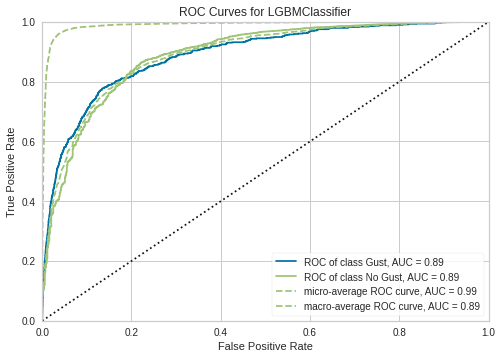

In [21]:
plot_model(model, plot = 'auc')

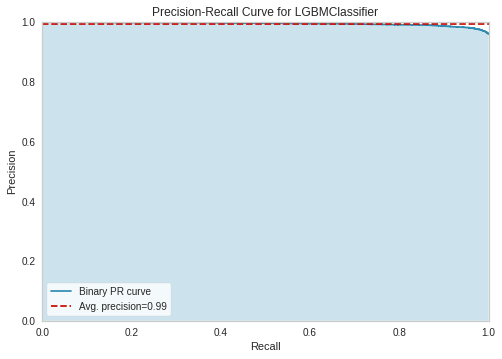

In [22]:
plot_model(model, plot = 'pr')

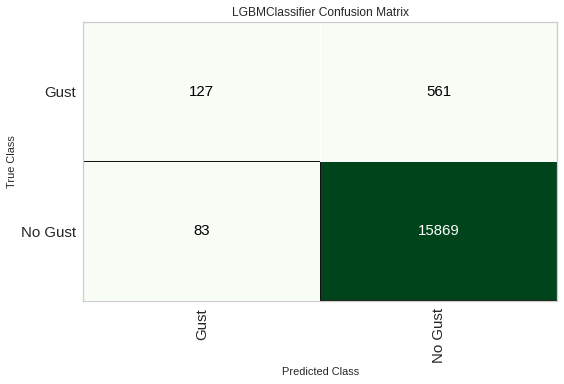

In [23]:
plot_model(model,'confusion_matrix')

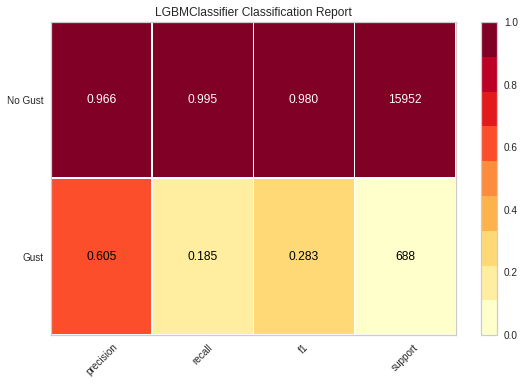

In [24]:
plot_model(model,'class_report')

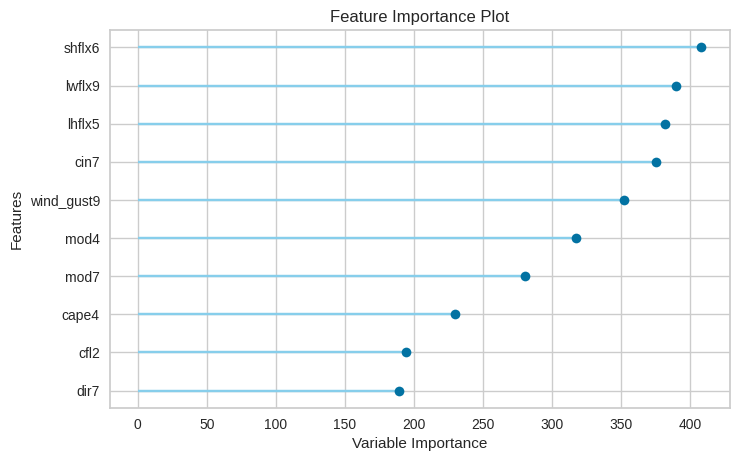

In [25]:
plot_model(model,"feature")

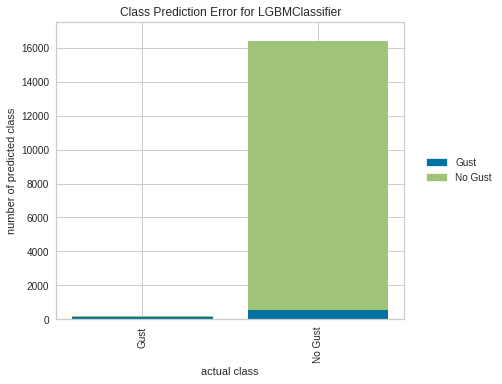

In [26]:
plot_model(model,"error")

**Export model**

In [27]:
x_var=get_config("X_train").columns
x_var

Index(['lhflx5', 'dir8', 'shflx6', 'cin7', 'dir2', 'dir5', 'lwflx9', 'cfl3',
       'dir9', 'dir0', 'mod7', 'wind_gust9', 'cfl2', 'dir4', 'dir7', 'mod4',
       'cape4', 'dir1'],
      dtype='object')

In [28]:
#define x and y
Y=df_all4k.gust_l
X=df_all4k[x_var]

In [29]:
#Run the machine learning model
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=1)
#ml_model=ExtraTreesClassifier(n_estimators=150).fit(X_train,y_train)
ml_model=LGBMClassifier(n_estimators=250).fit(X_train,y_train)


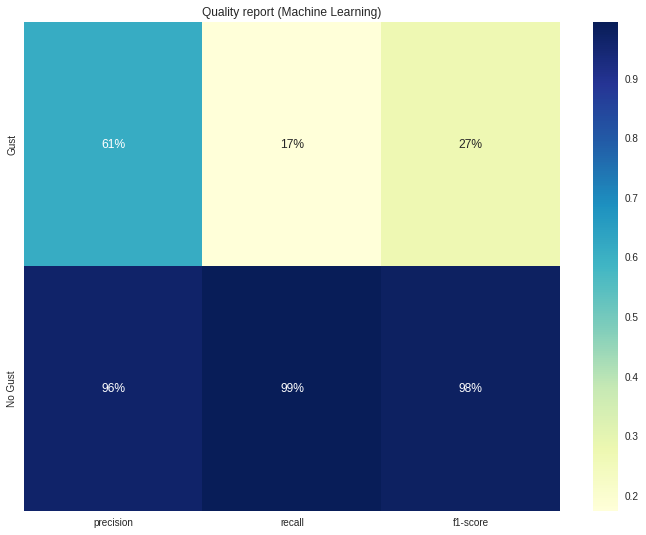

In [30]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
cr=pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
plt.figure(figsize=(12, 9))
plt.title("Quality report (Machine Learning)")
sns.heatmap(cr[:-3].drop(columns=["support"]),annot=True,cmap="YlGnBu",fmt='.0%');


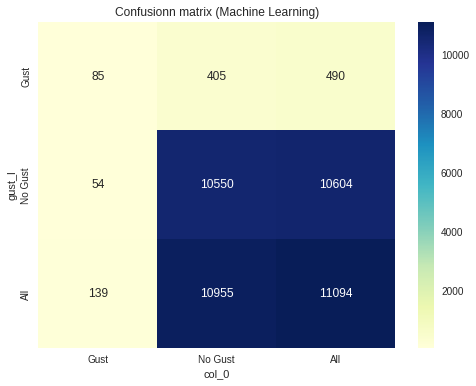

In [31]:
plt.figure(figsize=(8, 6))
plt.title("Confusionn matrix (Machine Learning)")
import seaborn as sns
global_sc=pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f');

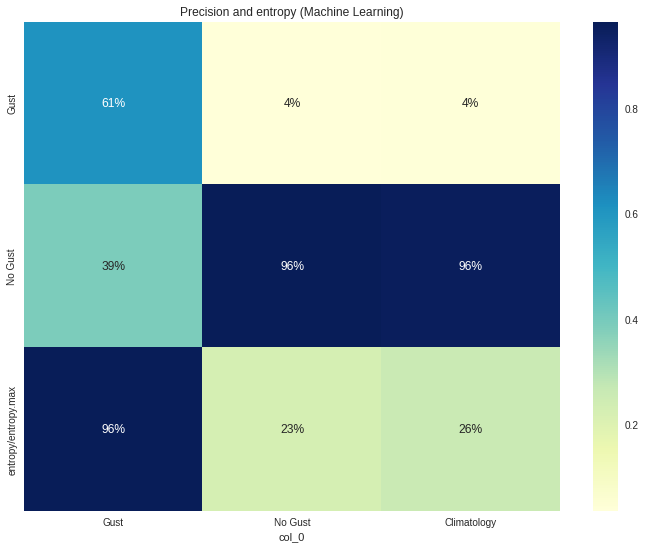

In [32]:
import math
from scipy.stats import entropy
plt.figure(figsize=(12, 9))
plt.title("Precision and entropy (Machine Learning)")
column_sc=pd.crosstab(y_test, ml_model.predict(X_test), margins=True,normalize="columns")
column_sc=column_sc.append(pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T).rename(columns={"All":"Climatology"})
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%');

In [33]:
import pickle
model_dict={"x_var":x_var,"ml_model":ml_model,"coor":coor}
pickle.dump(model_dict, open("gust_LEVX_d1.al", 'wb'))